In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io

pd.set_option("display.max_colwidth", None)

from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
!pip install wordcloud
!pip install mlxtend


In [5]:
df_ = pd.read_excel('Kaggle_Dataset/Global_Dataset.xlsx', usecols=['SEVERITY', 'DESCRIPTION'])
df = df_.copy()
df.head()

,SEVERITY,DESCRIPTION
0,MEDIUM,ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.
1,HIGH,"Buffer overflow in NFS mountd gives root access to remote attackers, mostly in Linux systems."
2,HIGH,Execute commands as root via buffer overflow in Tooltalk database server (rpc.ttdbserverd).
3,MEDIUM,"MIME buffer overflow in email clients, e.g. Solaris mailtool and Outlook."
4,HIGH,Arbitrary command execution via IMAP buffer overflow in authenticate command.


In [6]:
def df_stats(data):
    bold(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLS: {}".format(data.shape[1]))
    bold(" TYPES ".center(50, "#"))
    print(data.dtypes)
    bold(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    bold(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    #bold(" DESCRIBE ".center(50, "#"))
    #print(data.describe().T)
    bold(" MEMORY USAGE ".center(50, "#"))
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))

In [7]:
df_stats(df)

**##################### SHAPE ######################**

ROWS: 169566
COLS: 2


**##################### TYPES ######################**

SEVERITY       object
DESCRIPTION    object
dtype: object


**################# MISSING VALUES #################**

SEVERITY       86
DESCRIPTION     0
dtype: int64


**############### DUPLICATED VALUES ################**

NUMBER OF DUPLICATED VALUES: 7748


**################## MEMORY USAGE ##################**

Memory Usage: 2.6+ MB


In [8]:
df = df.dropna()

<Axes: ylabel='count'>

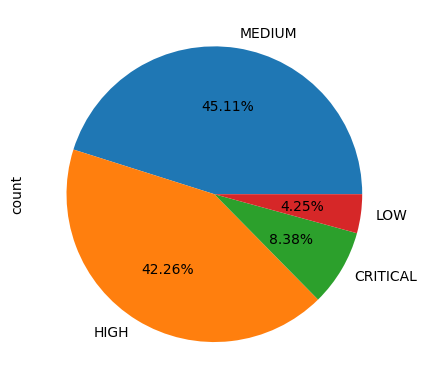

In [9]:
df["SEVERITY"].value_counts().plot(kind="pie", autopct="%.2f%%")

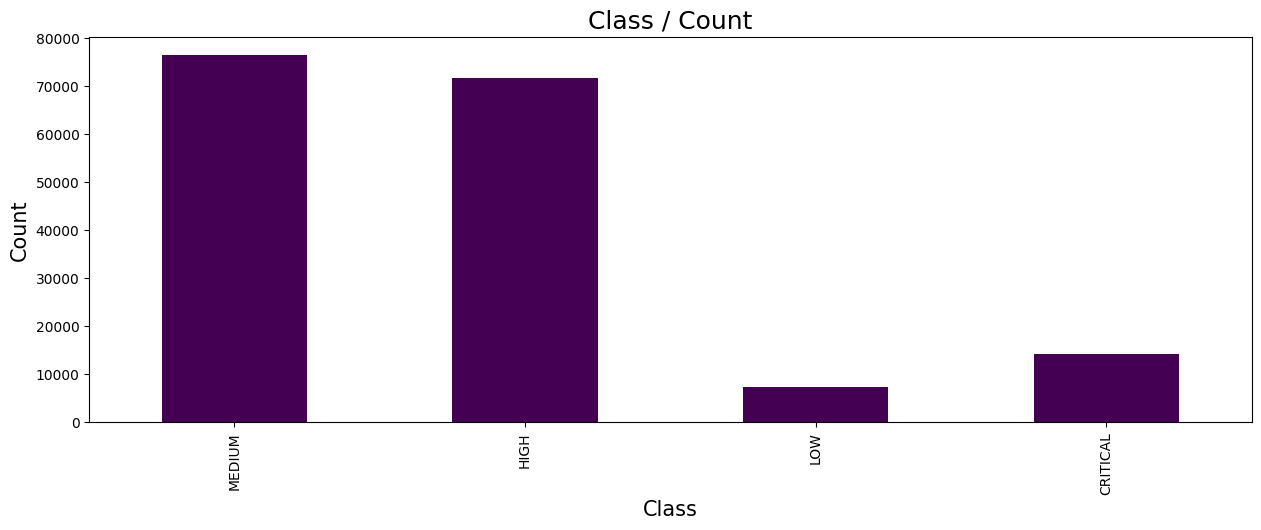

In [10]:
tags = Counter(df["SEVERITY"]).keys()
tags_len = Counter(df["SEVERITY"]).values()
tag_df = pd.DataFrame(zip(tags, tags_len), columns=["Class", "Count"])
tag_df.plot(x="Class", y="Count", kind="bar", legend=False, grid=False, figsize=(15, 5), cmap='viridis')
plt.title("Class / Count", fontsize=18)
plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [11]:


def word_freq(data, label, target, text, title):
    freq_df = data[data[target] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

[nltk_data] Downloading package punkt to C:\Users\lenovo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


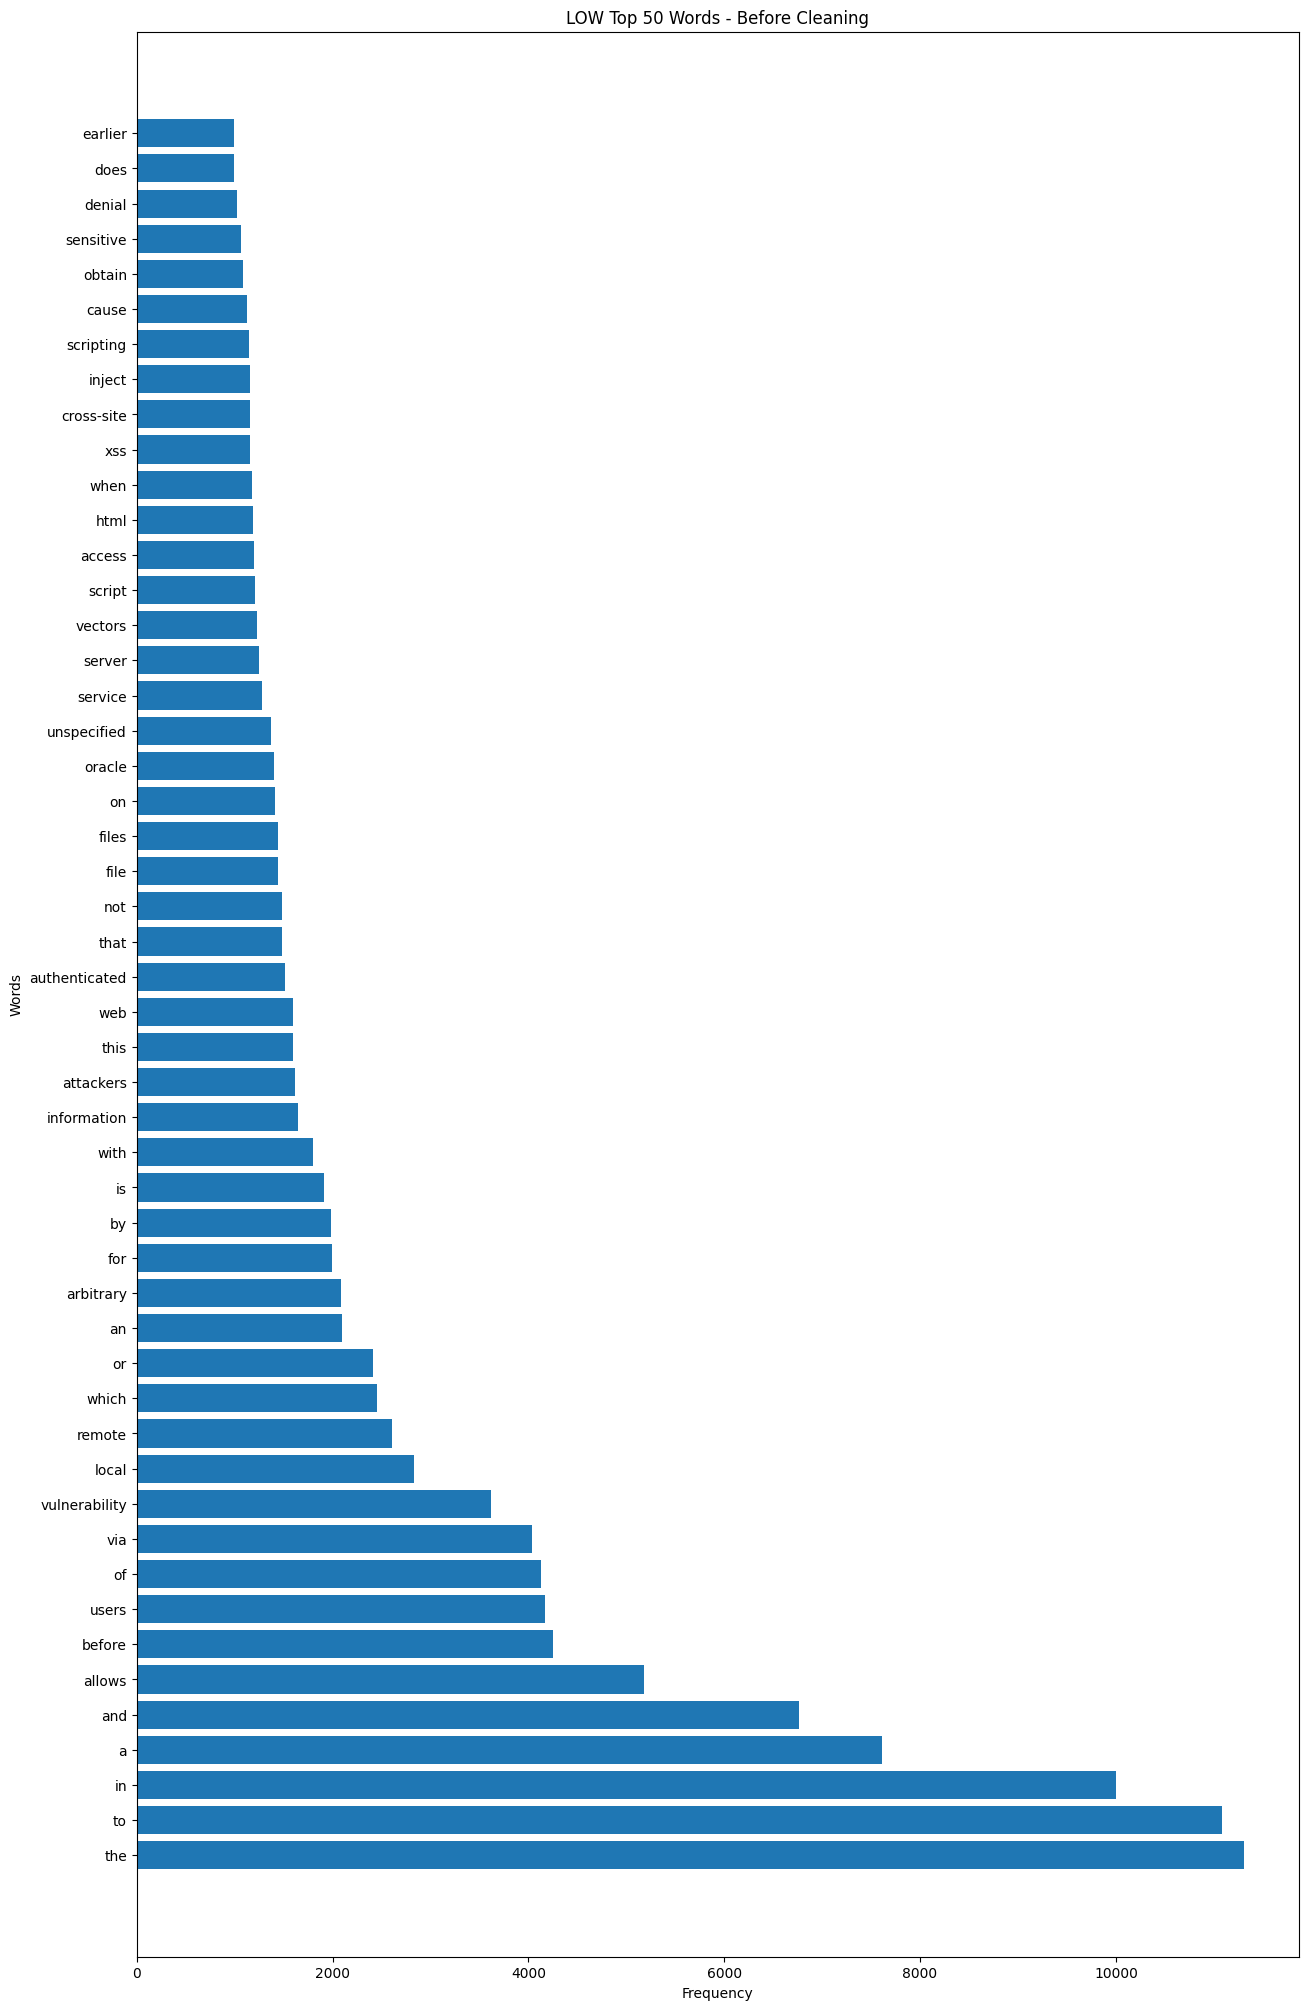

In [12]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

ham_low_top = word_freq(df, 'LOW', "SEVERITY", "DESCRIPTION", "LOW Top 50 Words - Before Cleaning")

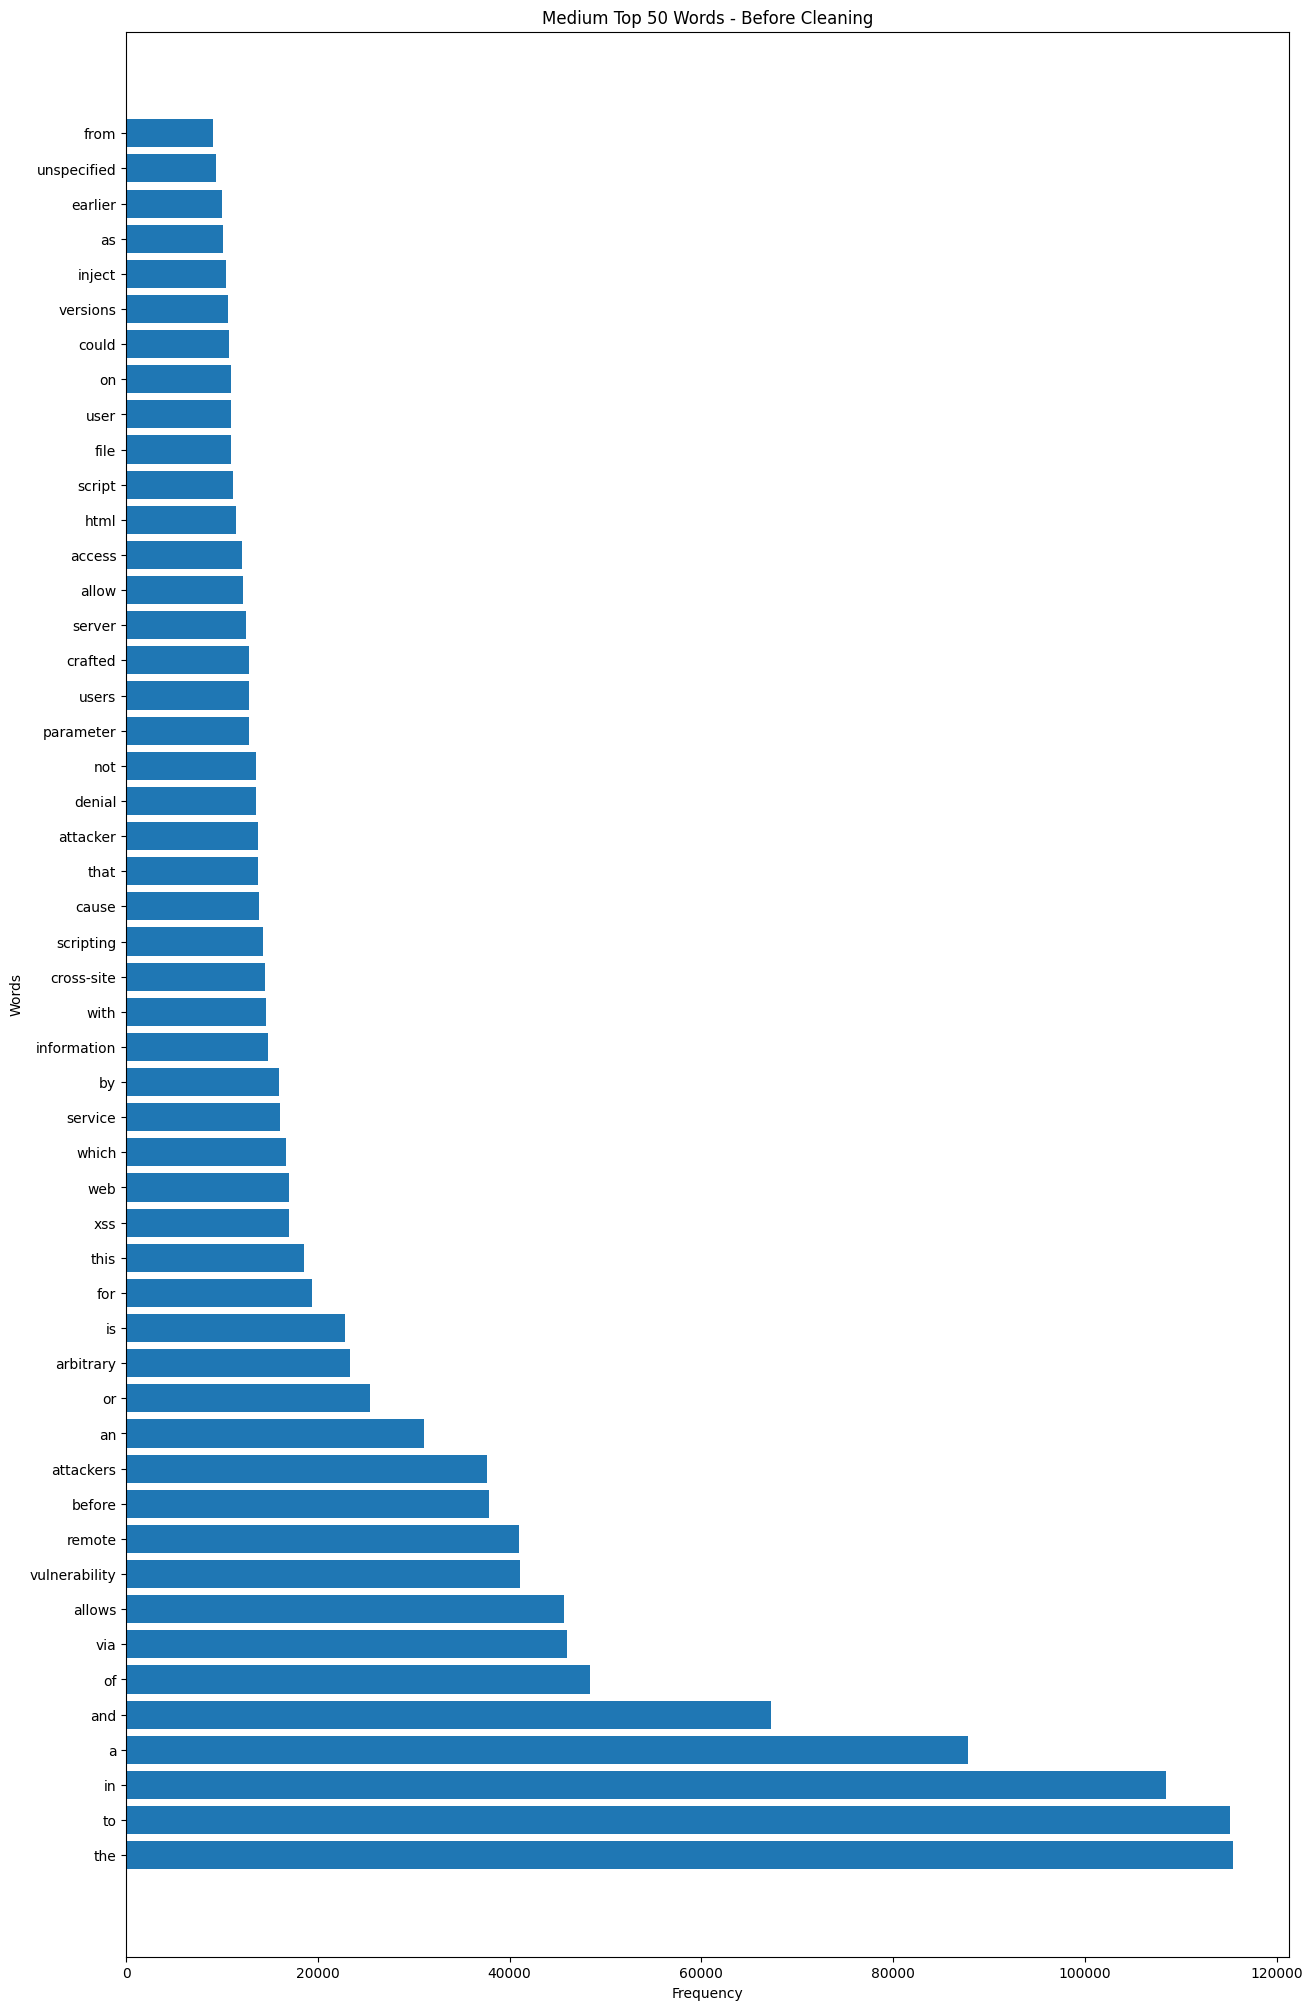

In [13]:
ham_medium_top = word_freq(df, 'MEDIUM', "SEVERITY", "DESCRIPTION", "Medium Top 50 Words - Before Cleaning")

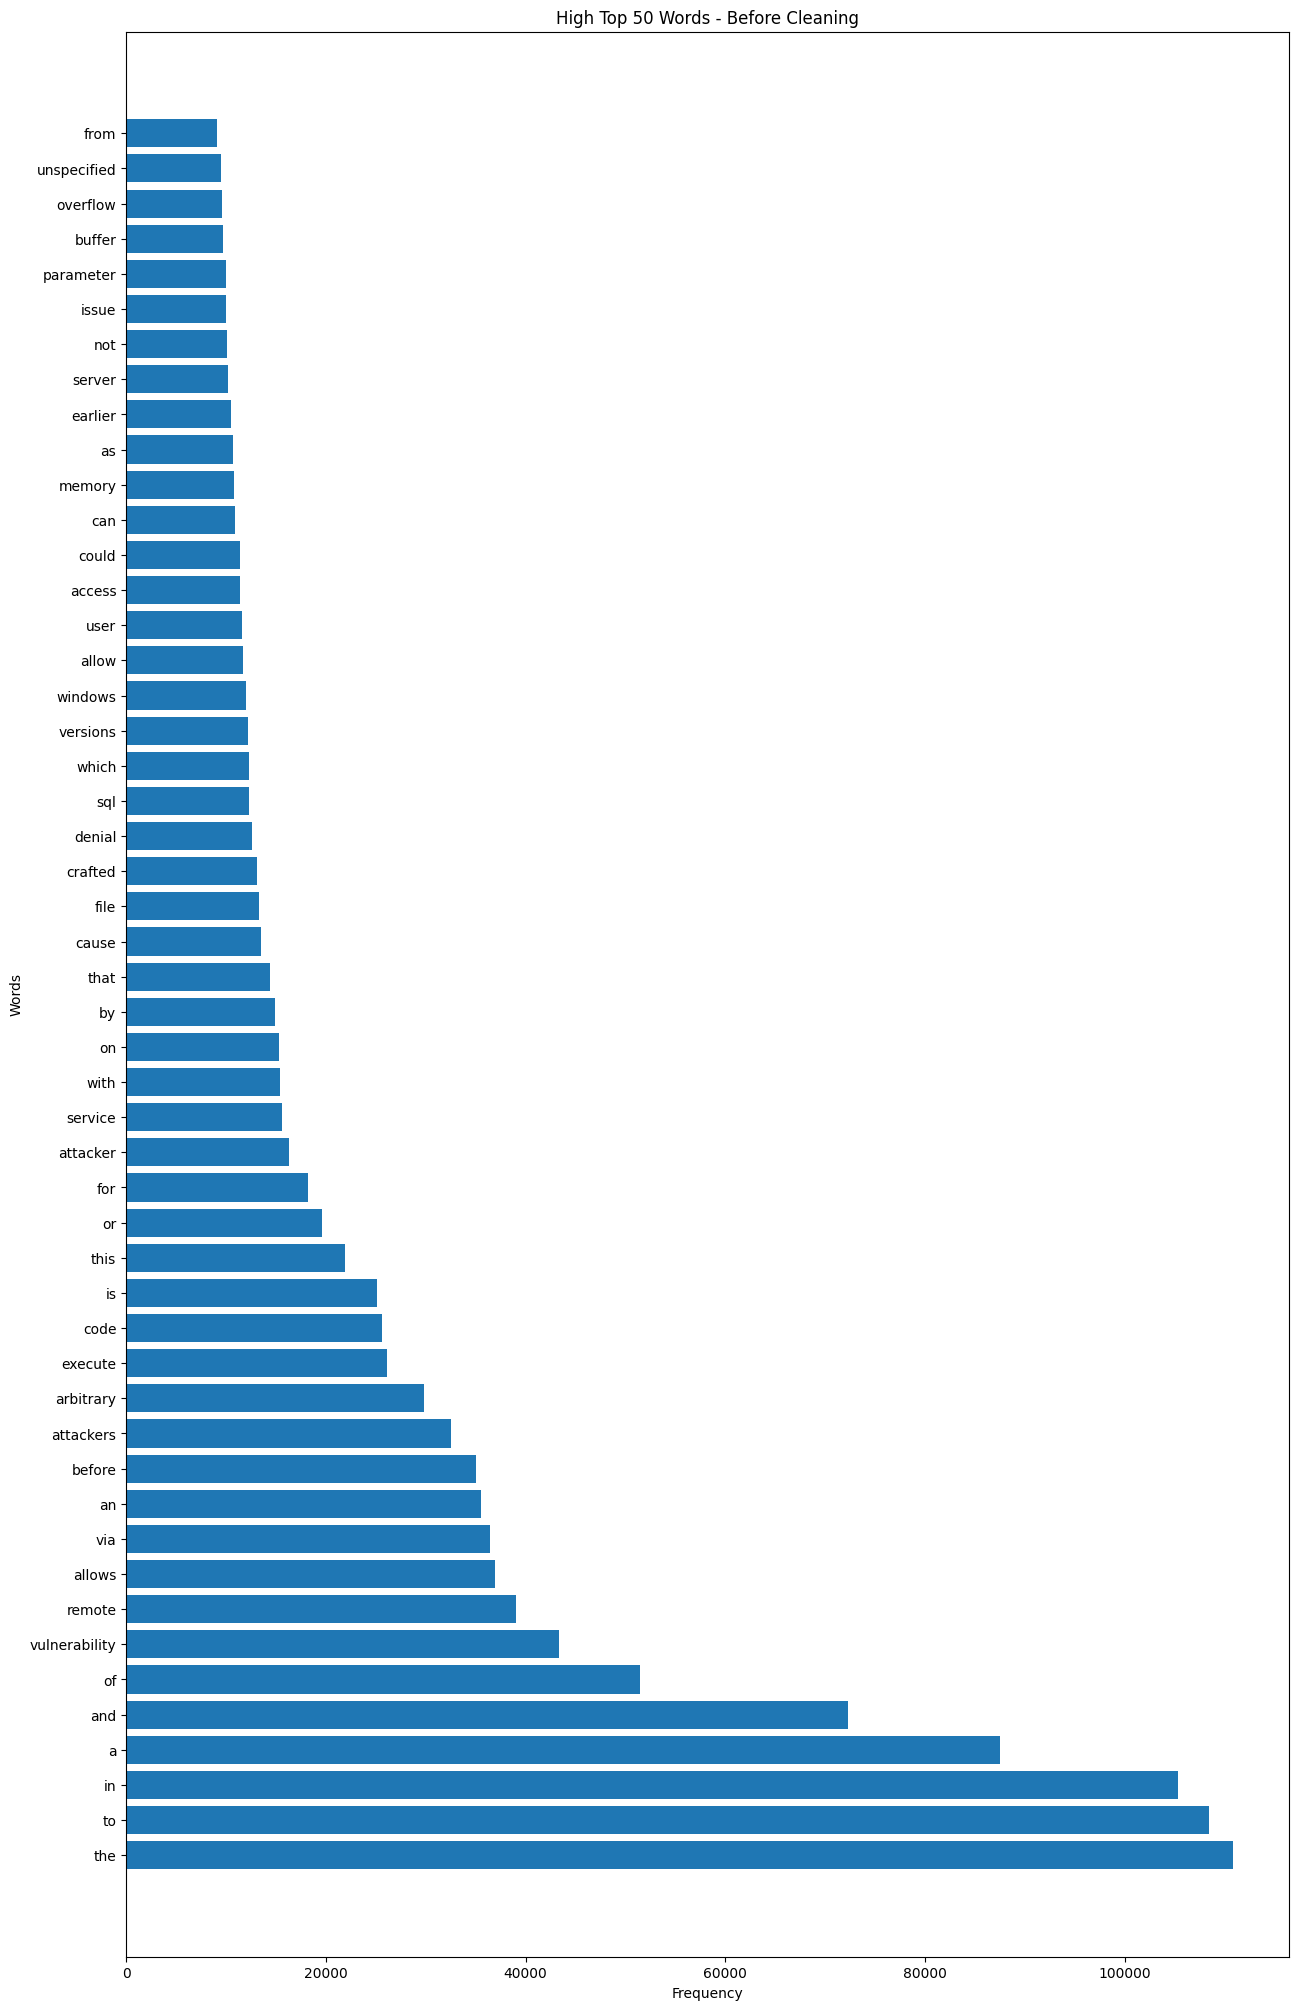

In [14]:
ham_high_top = word_freq(df, 'HIGH', "SEVERITY", "DESCRIPTION", "High Top 50 Words - Before Cleaning")

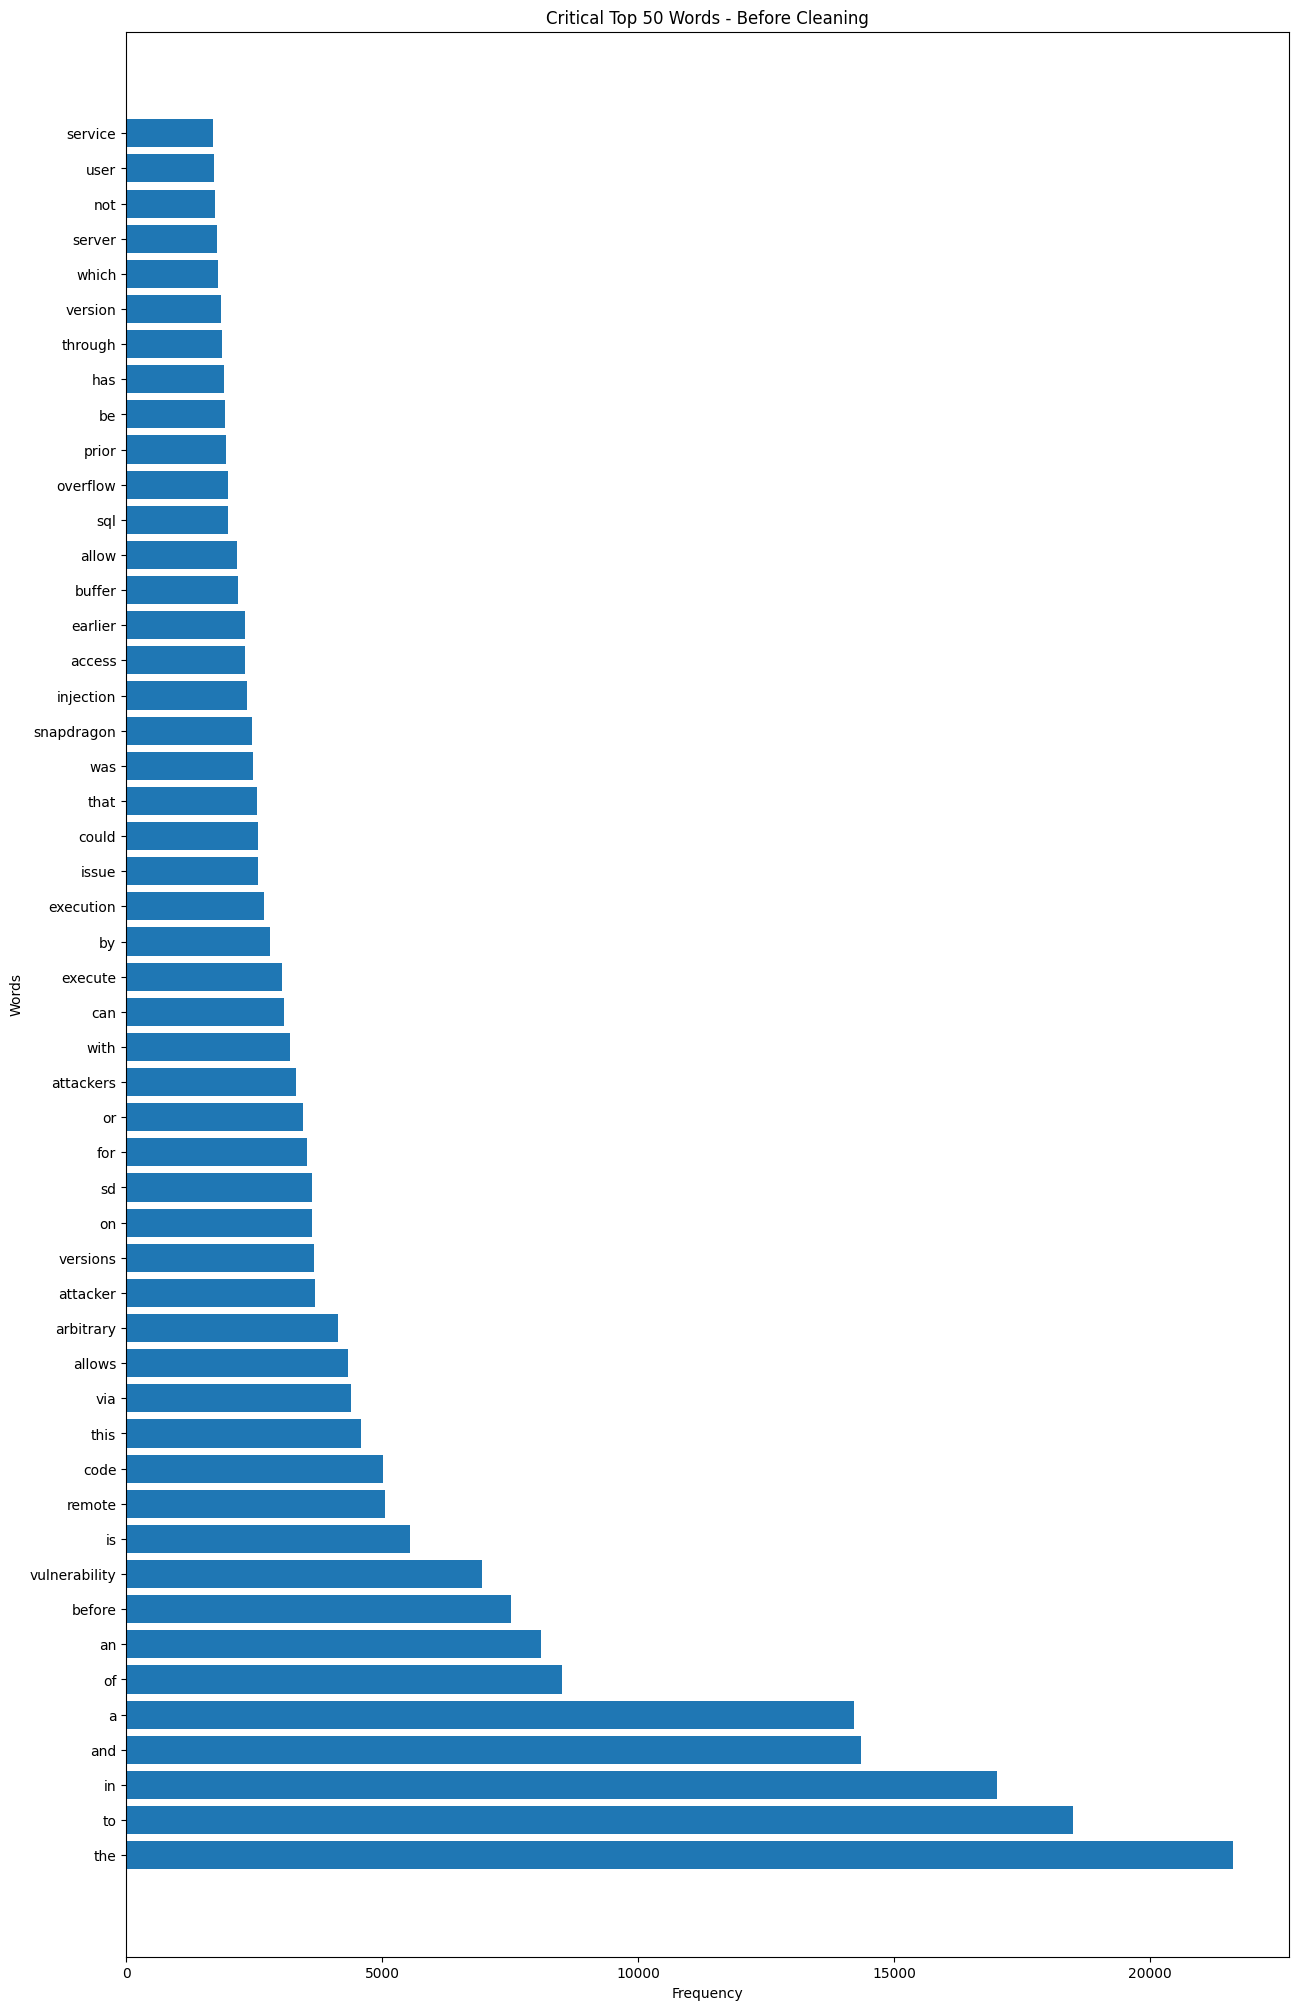

In [15]:
ham_critical_top = word_freq(df, 'CRITICAL', "SEVERITY", "DESCRIPTION", "Critical Top 50 Words - Before Cleaning")

In [16]:
smart_words = "SmartStoplist.txt"
smart_stoplist = []
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [17]:
nltk.download("popular")
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\lenovo/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\lenovo/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\lenovo/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\lenovo/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\lenovo/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\lenovo/nltk_data...
[nltk_data]    |   Package movie_review

In [18]:
def clean(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

In [19]:
df["CLEAN"] = df["DESCRIPTION"].apply(clean)

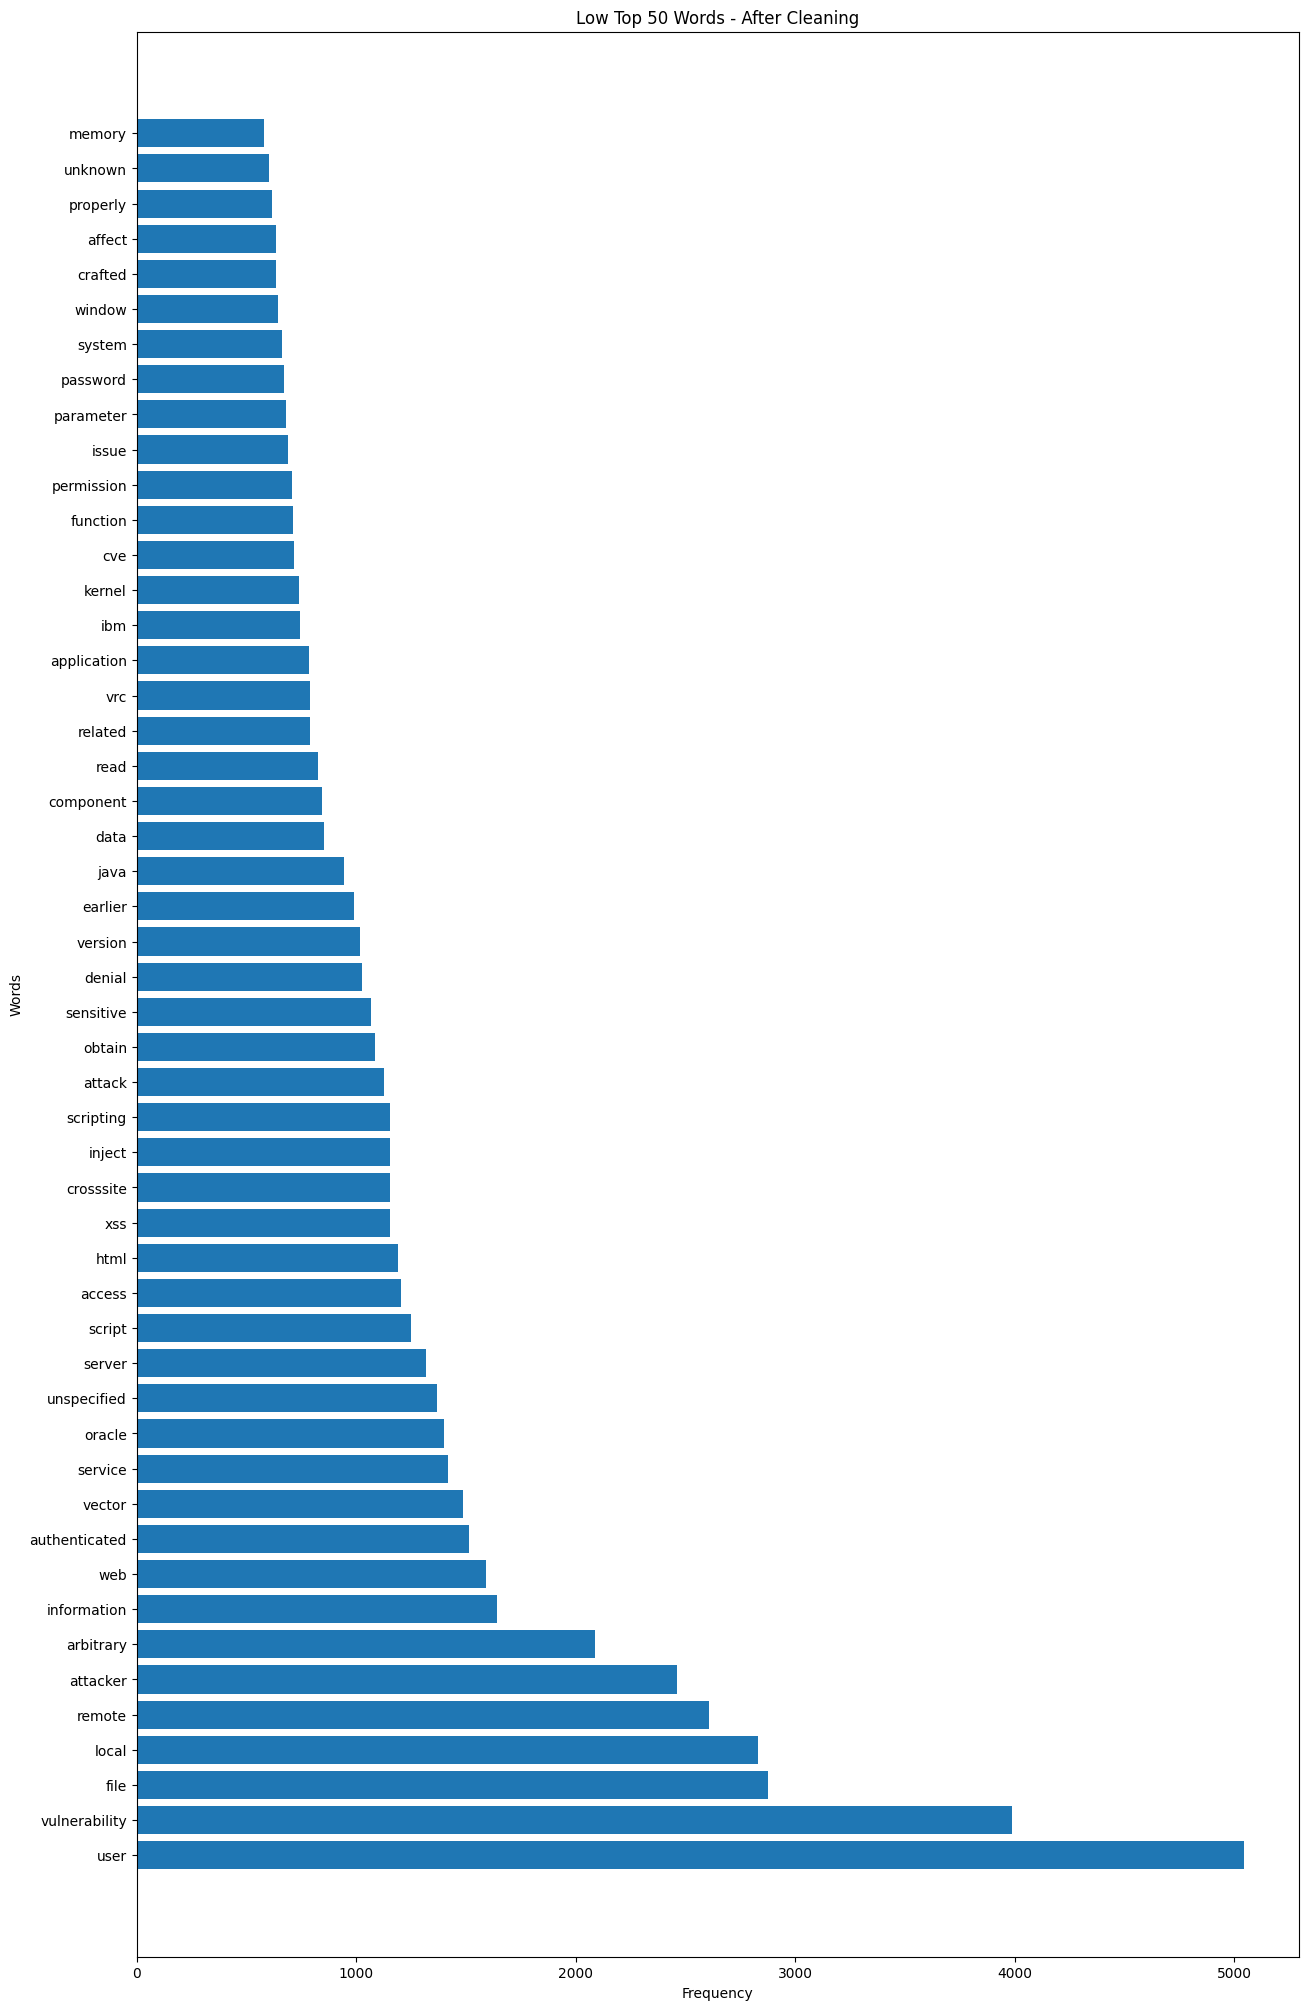

In [20]:
clean_low_top = word_freq(df, 'LOW', "SEVERITY", "CLEAN", "Low Top 50 Words - After Cleaning")

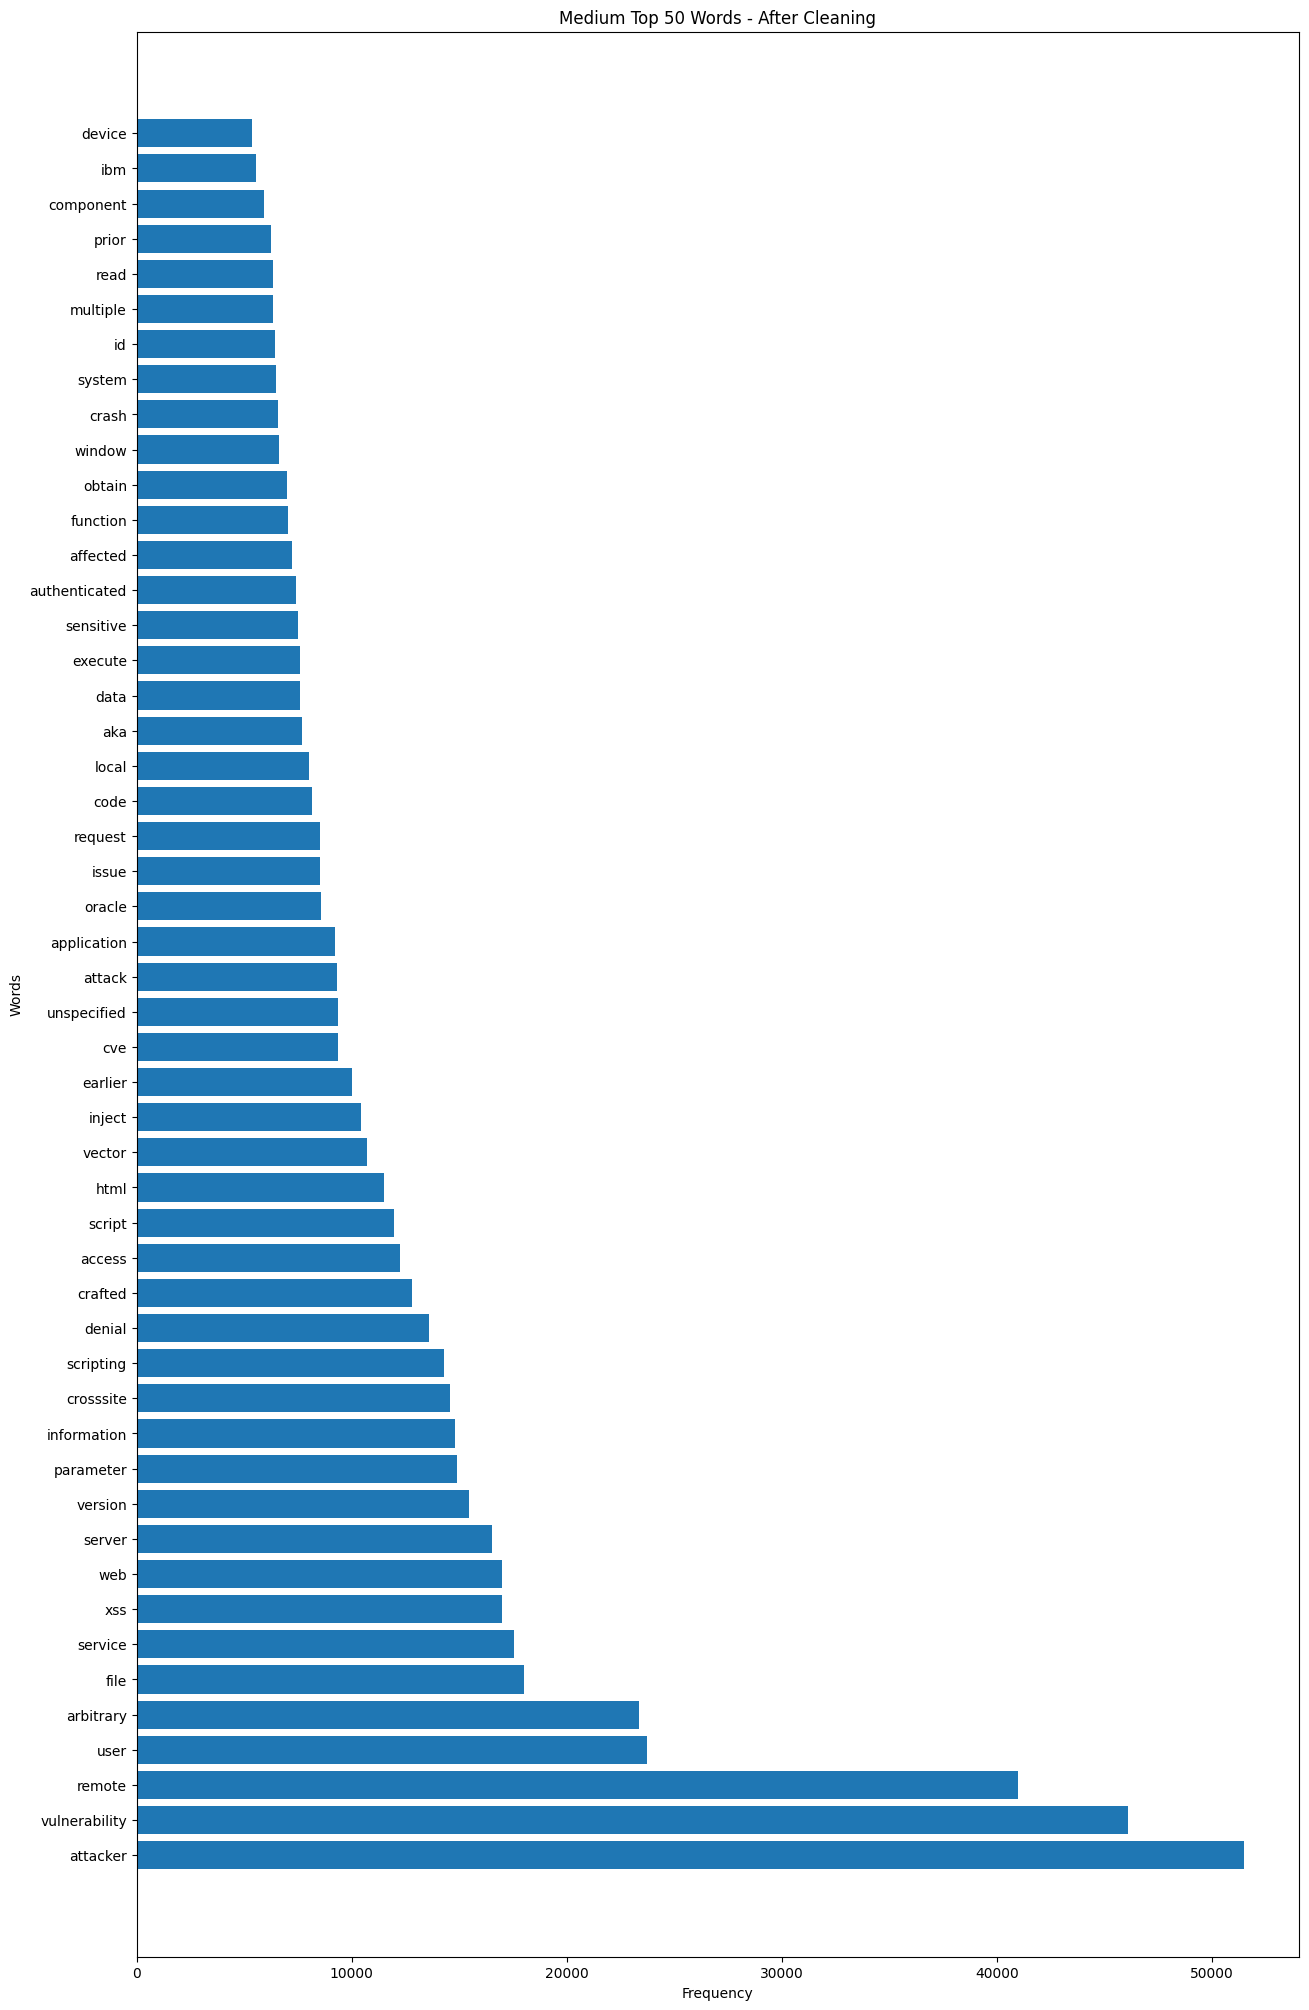

In [21]:
clean_medium_top = word_freq(df, 'MEDIUM', "SEVERITY", "CLEAN", "Medium Top 50 Words - After Cleaning")

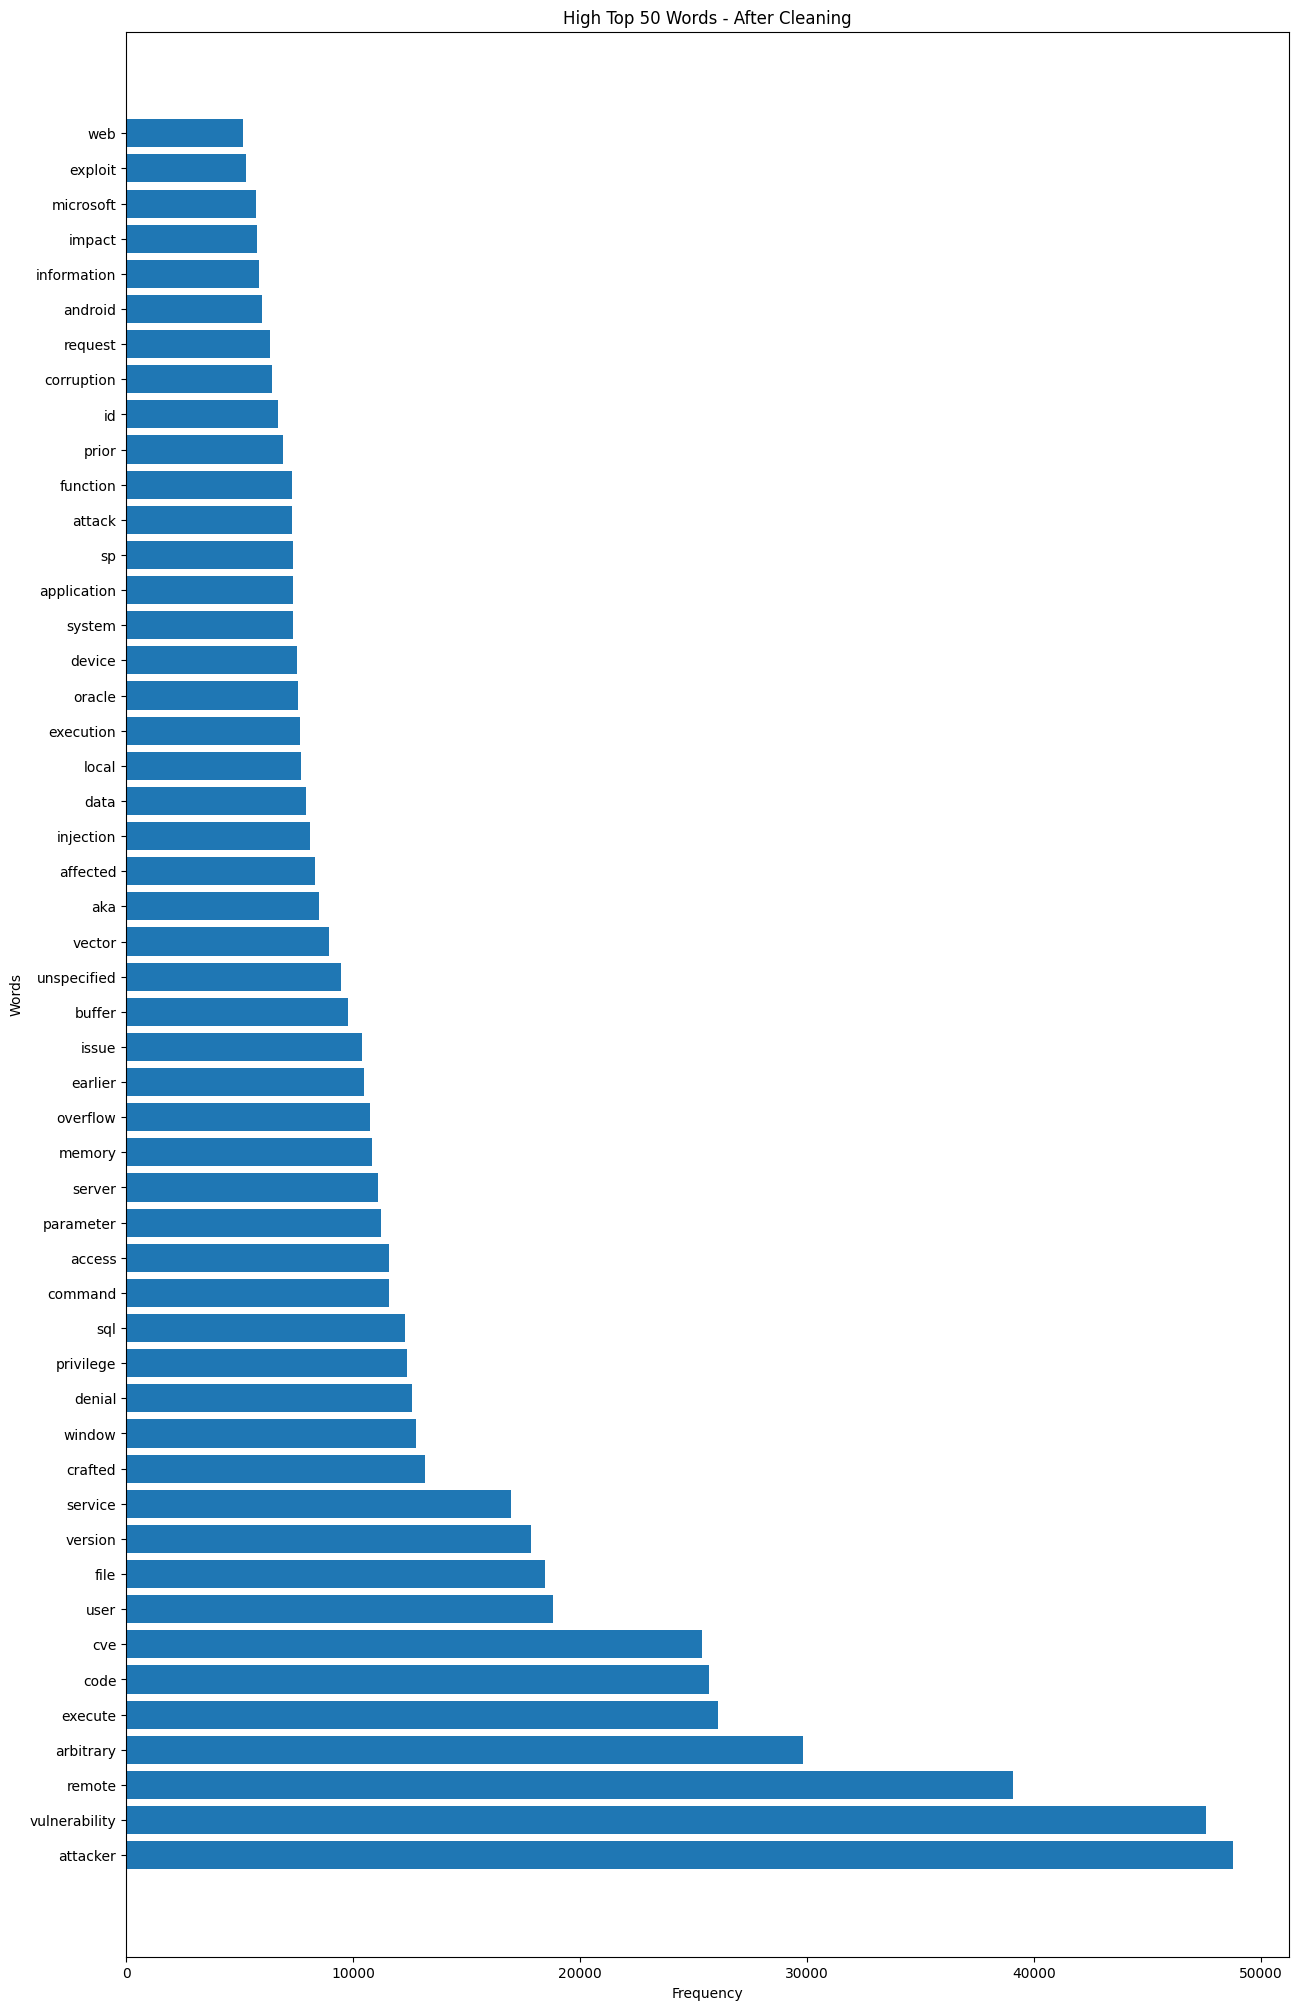

In [22]:
clean_high_top = word_freq(df, 'HIGH', "SEVERITY", "CLEAN", "High Top 50 Words - After Cleaning")

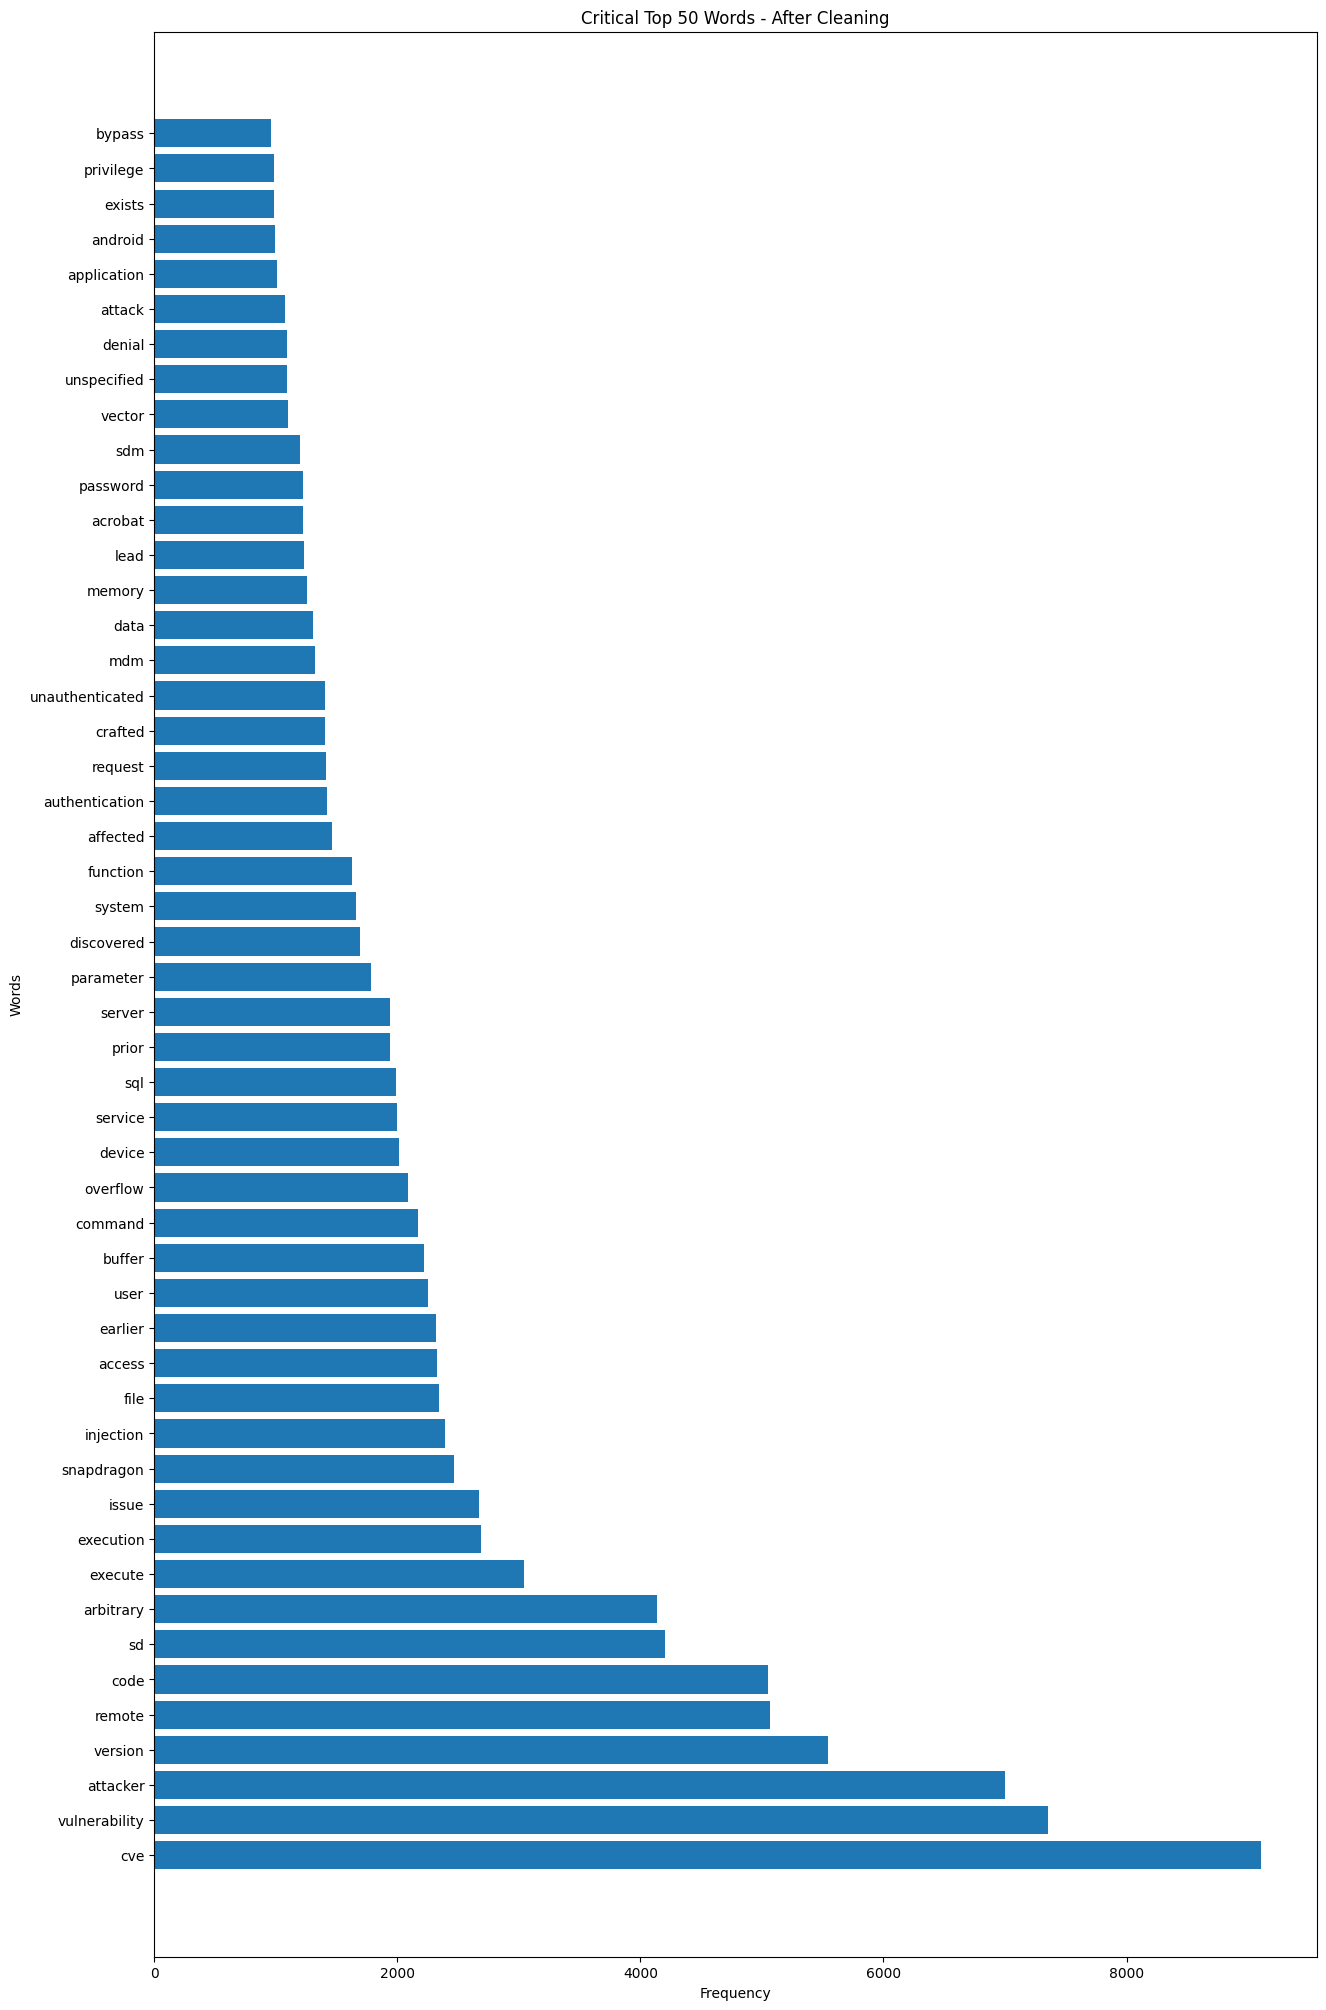

In [23]:
clean_critical_top = word_freq(df, 'CRITICAL', "SEVERITY", "CLEAN", "Critical Top 50 Words - After Cleaning")

In [24]:
le = LabelEncoder().fit(df["SEVERITY"])
le_nm = dict(zip(le.classes_, le.transform(le.classes_)))
df["LABELS"] = df["SEVERITY"].apply(lambda x: le_nm[x])
ndf = df.drop(["DESCRIPTION", "SEVERITY"], axis=1)

In [25]:
le.classes_
# 2 -> LOW
# 3 -> MEDIUM
# 1 -> HIGH
# 0 -> CRITICAL

array(['CRITICAL', 'HIGH', 'LOW', 'MEDIUM'], dtype=object)

In [26]:
# ndf.head()
## save the ndf dataframe
ndf.to_csv('dataset_2yr.csv', index=False)



In [27]:
X = ndf["CLEAN"]
y = ndf["LABELS"]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [30]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [31]:
maxlen = 70

In [32]:
tokenizer = Tokenizer(num_words=400000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ")
tokenizer.fit_on_texts(X)

In [33]:
word_index = tokenizer.word_index
len(word_index)

141132

In [34]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [35]:
input_dim = len(tokenizer.word_index) + 1
input_dim

141133

In [36]:
embeddings_index = {}
f = open("glove.840B.300d.txt", "r", encoding="utf-8")
for line in tqdm.tqdm(f):
    values = line.split(" ")
    word = values[0]
    c = np.asarray([float(value) for value in values[1:]])
    embeddings_index[word] = c

f.close()
print("Found %s word vectors." % len(embeddings_index))

0it [00:00, ?it/s]

2196018it [10:11, 3590.40it/s]


Found 2196017 word vectors.


In [37]:
embedding_matrix = np.zeros((input_dim, 300))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 141132/141132 [00:25<00:00, 5449.29it/s] 


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# Initialize the Logistic Regression model
lr = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
lr_tfidf_train_start = time.time()
lr.fit(X_train_tfidf, y_train)
lr_tfidf_train_end = time.time()
lr_tfidf_train_time = lr_tfidf_train_end - lr_tfidf_train_start
print("TFIDF + Logistic Regression Train Time = ", lr_tfidf_train_time)

TFIDF + Logistic Regression Train Time =  65.7582859992981


In [39]:
# Make predictions
lr_tfidf_pred_train = lr.predict(X_train_tfidf)
lr_tfidf_test_start = time.time()
lr_tfidf_pred_test = lr.predict(X_test_tfidf)
lr_tfidf_test_end = time.time()
lr_tfidf_test_time = lr_tfidf_test_end - lr_tfidf_test_start

In [40]:
# Calculate scores
lr_tfidf_train_score = accuracy_score(lr_tfidf_pred_train, y_train)
lr_tfidf_test_score = accuracy_score(lr_tfidf_pred_test, y_test)
print(f"TFIDF + Logistic Regression Train Score = {lr_tfidf_train_score * 100:.2f}%")
print(f"TFIDF + Logistic Regression Test Score = {lr_tfidf_test_score * 100:.2f}%")
print(f"TFIDF + Logistic Regression Test Time = ", lr_tfidf_test_time)

TFIDF + Logistic Regression Train Score = 79.56%
TFIDF + Logistic Regression Test Score = 72.69%
TFIDF + Logistic Regression Test Time =  0.07344579696655273


In [41]:
# Calculate additional metrics
lr_tfidf_precision_score = precision_score(y_test, lr_tfidf_pred_test, average="weighted")
lr_tfidf_f1_score = f1_score(y_test, lr_tfidf_pred_test, average="weighted")
lr_tfidf_recall_score = recall_score(y_test, lr_tfidf_pred_test, average="weighted")
lr_tfidf_accuracy_score = accuracy_score(y_test, lr_tfidf_pred_test)

print(f"TFIDF + Logistic Regression Precision Score = {lr_tfidf_precision_score * 100:.2f}%")
print(f"TFIDF + Logistic Regression F1 Score = {lr_tfidf_f1_score * 100:.2f}%")
print(f"TFIDF + Logistic Regression Recall Score = {lr_tfidf_recall_score * 100:.2f}%")
print(f"TFIDF + Logistic Regression Accuracy Score = {lr_tfidf_accuracy_score * 100:.2f}%")

TFIDF + Logistic Regression Precision Score = 71.98%
TFIDF + Logistic Regression F1 Score = 71.63%
TFIDF + Logistic Regression Recall Score = 72.69%
TFIDF + Logistic Regression Accuracy Score = 72.69%


In [42]:
# Print classification report
print(classification_report(y_test, lr_tfidf_pred_test, target_names=le.classes_))

              precision    recall  f1-score   support

    CRITICAL       0.65      0.37      0.47      2846
        HIGH       0.72      0.77      0.74     14297
         LOW       0.57      0.23      0.33      1435
      MEDIUM       0.75      0.80      0.78     15318

    accuracy                           0.73     33896
   macro avg       0.67      0.54      0.58     33896
weighted avg       0.72      0.73      0.72     33896



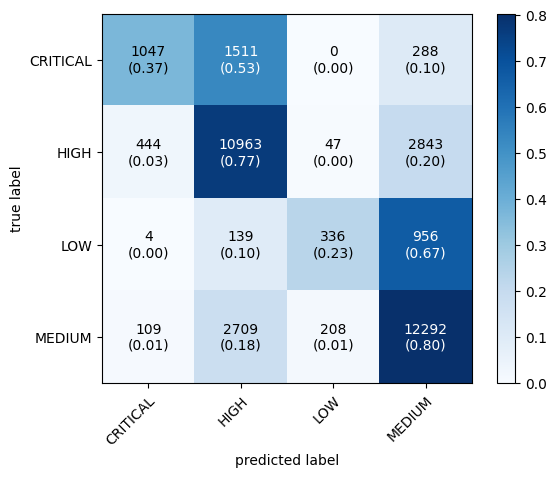

In [43]:
# Plot confusion matrix
lr_tfidf_cm = confusion_matrix(y_test, lr_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lr_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_)
plt.show()

In [44]:
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

In [45]:
num_classes = len(np.unique(y_train))

In [48]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

maxlen = 128


train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=maxlen, return_tensors='tf')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=maxlen, return_tensors='tf')


train_labels = tf.convert_to_tensor(y_train)
test_labels = tf.convert_to_tensor(y_test)

num_labels = len(set(y_train)) 
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(16)


test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)


optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            inputs = {k: v for k, v in batch[0].items()}
            labels = batch[1]
            outputs = model(inputs, training=True)
            loss = loss_fn(labels, outputs.logits)
        
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        total_loss += loss
        predictions = tf.argmax(outputs.logits, axis=-1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(predictions, tf.int64), tf.cast(labels, tf.int64)), tf.float32))
        total_accuracy += accuracy
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {avg_accuracy:.4f}")


total_loss = 0
total_accuracy = 0
num_batches = 0

for batch in test_dataset:
    inputs = {k: v for k, v in batch[0].items()}
    labels = batch[1]
    outputs = model(inputs, training=False)
    loss = loss_fn(labels, outputs.logits)
    
    total_loss += loss
    predictions = tf.argmax(outputs.logits, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    total_accuracy += accuracy
    num_batches += 1

avg_loss = total_loss

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


KeyboardInterrupt: 

In [ ]:
predictions = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
predicted_labels = tf.argmax(predictions.logits, axis=1)


results = model.evaluate([test_encodings['input_ids'], test_encodings['attention_mask']], test_labels)
print(f"Test Accuracy: {results[1] * 100:.2f}%")


### Loading original CVE dataset

In [45]:
import os
import json
import pandas as pd

# Function to flatten JSON data
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x:
                flatten(x[a], name + a + '_')
        elif isinstance(x, list):
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Base directory containing year-wise folders
base_directory = r'C:\Users\lenovo\OneDrive\Documents\NLP\NLP_Project_Group35\cvelistV5-main\cvelistV5-main\cves'

# Years for which we want to extract data
years_to_include = ['1999', '2000']

# List to store flattened JSON data
flat_json_data = []

# Iterate through the directories for the years 1999 and 2000
for year in years_to_include:
    year_directory = os.path.join(base_directory, year)
    
    # Check if the directory exists (to avoid errors if a year folder is missing)
    if os.path.exists(year_directory):
        for root, dirs, files in os.walk(year_directory):
            for filename in files:
                if filename.endswith('.json'):
                    file_path = os.path.join(root, filename)
                    with open(file_path, 'r') as file:
                        json_obj = json.load(file)
                        flat_json_data.append(flatten_json(json_obj))

# Convert the list of flattened JSON data to a DataFrame
df = pd.DataFrame(flat_json_data)

# Display the DataFrame
print(df)

Empty DataFrame
Columns: []
Index: []


In [113]:
df.head()

,containers_cna_affected_0_product,containers_cna_affected_0_vendor,containers_cna_affected_0_versions_0_status,containers_cna_affected_0_versions_0_version,containers_cna_descriptions_0_lang,containers_cna_descriptions_0_value,containers_cna_problemTypes_0_descriptions_0_description,containers_cna_problemTypes_0_descriptions_0_lang,containers_cna_problemTypes_0_descriptions_0_type,containers_cna_providerMetadata_dateUpdated,...,containers_adp_0_references_17_name,containers_adp_0_references_17_tags_0,containers_adp_0_references_17_tags_1,containers_adp_0_references_17_tags_2,containers_adp_0_references_17_url,containers_adp_0_references_18_name,containers_adp_0_references_18_tags_0,containers_adp_0_references_18_tags_1,containers_adp_0_references_18_tags_2,containers_adp_0_references_18_url
0,n/a,n/a,affected,n/a,en,ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.,n/a,en,text,2005-12-17T00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,n/a,n/a,affected,n/a,en,"Buffer overflow in NFS mountd gives root access to remote attackers, mostly in Linux systems.",n/a,en,text,2005-11-02T10:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,n/a,n/a,affected,n/a,en,Execute commands as root via buffer overflow in Tooltalk database server (rpc.ttdbserverd).,n/a,en,text,2005-11-02T10:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,n/a,n/a,affected,n/a,en,"MIME buffer overflow in email clients, e.g. Solaris mailtool and Outlook.",n/a,en,text,2018-10-12T19:57:01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,n/a,n/a,affected,n/a,en,Arbitrary command execution via IMAP buffer overflow in authenticate command.,n/a,en,text,2005-11-02T10:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
df=df[['cveMetadata_cveId', 'containers_cna_descriptions_0_value']]

In [115]:
df.head()

,cveMetadata_cveId,containers_cna_descriptions_0_value
0,CVE-1999-0001,ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.
1,CVE-1999-0002,"Buffer overflow in NFS mountd gives root access to remote attackers, mostly in Linux systems."
2,CVE-1999-0003,Execute commands as root via buffer overflow in Tooltalk database server (rpc.ttdbserverd).
3,CVE-1999-0004,"MIME buffer overflow in email clients, e.g. Solaris mailtool and Outlook."
4,CVE-1999-0005,Arbitrary command execution via IMAP buffer overflow in authenticate command.


In [116]:
df.rename(columns={'containers_cna_descriptions_0_value': 'DESCRIPTION'}, inplace=True)


In [117]:
df["DESCRIPTION"] = df["DESCRIPTION"].astype(str)
df["CLEAN"] = df["DESCRIPTION"].apply(clean)

In [118]:
df.head()

,cveMetadata_cveId,DESCRIPTION,CLEAN
0,CVE-1999-0001,ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.,ip_inputc bsdderived tcpip implementation remote attacker denial service crash hang crafted packet
1,CVE-1999-0002,"Buffer overflow in NFS mountd gives root access to remote attackers, mostly in Linux systems.",buffer overflow nfs mountd root access remote attacker linux system
2,CVE-1999-0003,Execute commands as root via buffer overflow in Tooltalk database server (rpc.ttdbserverd).,execute command root buffer overflow tooltalk database server rpcttdbserverd
3,CVE-1999-0004,"MIME buffer overflow in email clients, e.g. Solaris mailtool and Outlook.",mime buffer overflow email client solaris mailtool outlook
4,CVE-1999-0005,Arbitrary command execution via IMAP buffer overflow in authenticate command.,arbitrary command execution imap buffer overflow authenticate command


In [119]:
X = ndf["CLEAN"]

In [120]:
X_test_tfidf = tfidf.transform(X)

In [121]:
X_test_cv = cv.transform(X)


In [125]:
lr_tfidf_pred_test = lr.predict(X_test_tfidf)

In [127]:
print(lr_tfidf_pred_test)


[3 1 1 ... 3 3 3]


In [138]:

# Create a DataFrame for X_test
df_X_test = pd.DataFrame(X)

# Add the predicted values to the DataFrame
df_X_test['Predicted'] = lr_tfidf_pred_test

# Display the DataFrame
df_X_test.head()

,CLEAN,Predicted
0,ip_inputc bsdderived tcpip implementation remote attacker denial service crash hang crafted packet,3
1,buffer overflow nfs mountd root access remote attacker linux system,1
2,execute command root buffer overflow tooltalk database server rpcttdbserverd,1
3,mime buffer overflow email client solaris mailtool outlook,1
4,arbitrary command execution imap buffer overflow authenticate command,1


In [139]:
# Mapping of numeric labels to string values
label_mapping = {
    0: 'CRITICAL',
    1: 'HIGH',
    2: 'LOW',
    3: 'MEDIUM'
}

# Replace the numeric values with string labels in the 'Predicted' column
df_X_test['Predicted'] = df_X_test['Predicted'].map(label_mapping)
df_X_test.rename(columns={'CLEAN': 'Description'}, inplace=True)
# Display the updated DataFrame
df_X_test.head()

,Description,Predicted
0,ip_inputc bsdderived tcpip implementation remote attacker denial service crash hang crafted packet,MEDIUM
1,buffer overflow nfs mountd root access remote attacker linux system,HIGH
2,execute command root buffer overflow tooltalk database server rpcttdbserverd,HIGH
3,mime buffer overflow email client solaris mailtool outlook,HIGH
4,arbitrary command execution imap buffer overflow authenticate command,HIGH


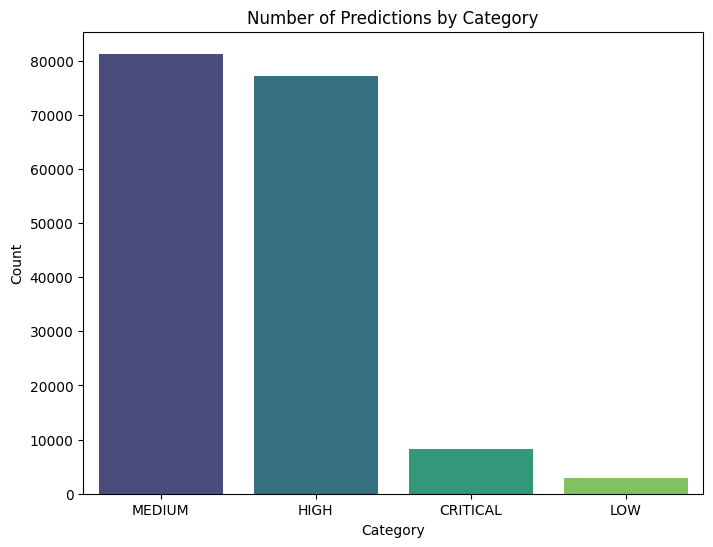

In [140]:
# Count the occurrences of each category in the 'Predicted' column
category_counts = df_X_test['Predicted'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Number of Predictions by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

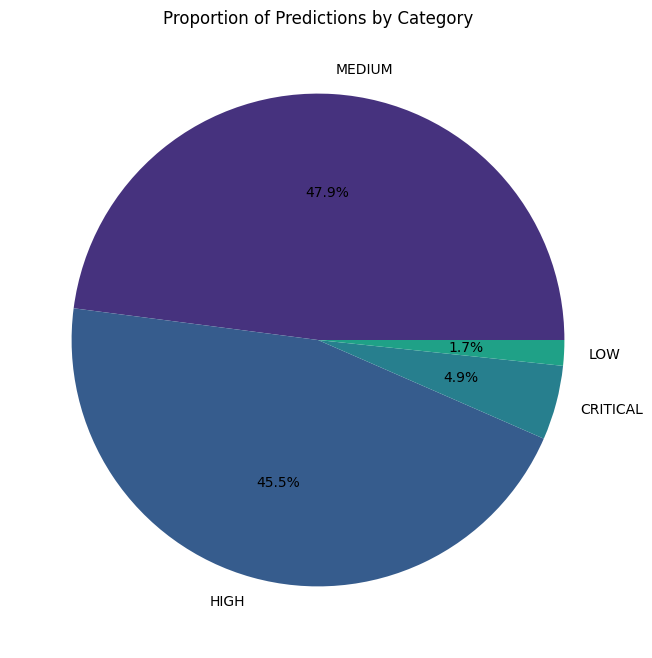

In [141]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Proportion of Predictions by Category')
plt.show()

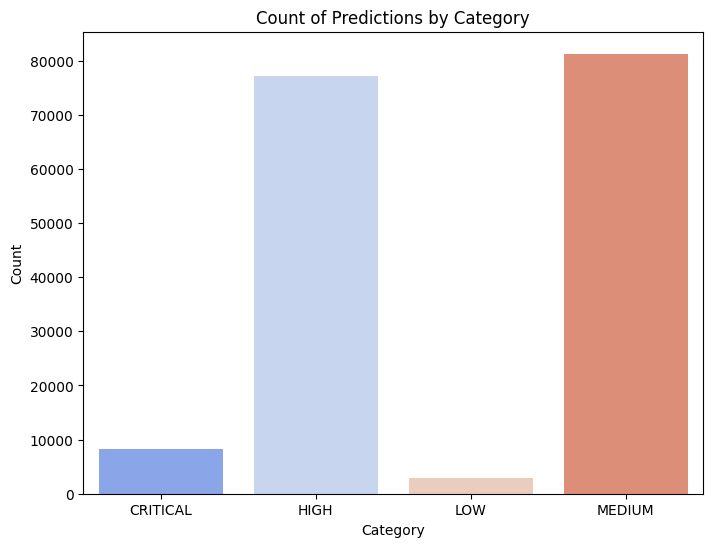

In [142]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Predicted', data=df_X_test, palette='coolwarm', order=['CRITICAL', 'HIGH', 'LOW', 'MEDIUM'])
plt.title('Count of Predictions by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()